### Se importan las librerías:

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

from GPUtil import showUtilization as gpu_usage

import time
import os

import segmentation_models_pytorch as smp

c:\Users\pecos\anaconda3\envs\geo_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch utiliza {}".format("GPU" if torch.cuda.is_available() else "CPU"))

PyTorch utiliza GPU


### Constantes:

In [3]:
IMAGE_PATH = './segmentation/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = './segmentation/dataset/semantic_drone_dataset/label_images_semantic/'

### Funciones Útiles:

In [4]:
def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    print("GPU Usage after emptying the cache")
    gpu_usage()
free_gpu_cache()

Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
GPU Usage after emptying the cache
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [5]:
def create_df(path=IMAGE_PATH):
    name = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

In [6]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean=None, std= None, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Se lee la imagen según su indice
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        # Convierte los colores de la imagen de BGR a RGB  
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Se lee la máscara según su indice
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is None:
            img = Image.fromarray(img)
        else:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.mean and self.std:
            t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
            img = t(img)

        mask = torch.from_numpy(mask).long()
            
        return img, mask

In [7]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [8]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [9]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [10]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []
    val_acc = []
    train_iou = []
    train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1
    not_improve = 0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(train_loader):
            #training phase
            image_tiles, mask_tiles = data            
            image = image_tiles.to(device)
            mask = mask_tiles.to(device)
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(val_loader):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data
                    image = image_tiles.to(device)
                    mask = mask_tiles.to(device)
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, './models/Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [11]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device)
    image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [12]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device)
    image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [13]:
def predict_image_mask(model, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device)
    image=image.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0)
        
    output = model(image)
    masked = torch.argmax(output, dim=1)
    masked = masked.cpu().squeeze(0)
    return masked

In [14]:
def miou_score(model, test_set):
    score_iou = []
    for i in range(len(test_set)):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [15]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in range(len(test_set)):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [16]:
def plot_colortable(colors, title, sort_colors=True, emptycols=0):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12
    topmargin = 40

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
        names = [name for hsv, name in by_hsv]
    else:
        names = list(colors)

    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-topmargin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()
    ax.set_title(title, fontsize=24, loc="left", pad=10)

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

### Preprocesamiento:

Crear Data Frame:

In [17]:
n_classes = 23 
df = create_df()
print('Total Images: ', len(df))

Total Images:  400


Dividir Data:

In [18]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.3, random_state=33)
X_train, X_val = train_test_split(X_trainval, test_size=15/70, random_state=33)

print('Train Size:', len(X_train), '({}%)'.format(round((len(X_train)/len(df))*100, 2)))
print('Val Size:', len(X_val), '({}%)'.format(round((len(X_val)/len(df))*100, 2)))
print('Test Size:', len(X_test), '({}%)'.format(round((len(X_test)/len(df))*100, 2)))

Train Size: 220 (55.0%)
Val Size: 60 (15.0%)
Test Size: 120 (30.0%)


Tamaño de imagen: (4000, 6000, 3)
Tamaño de máscara (4000, 6000)


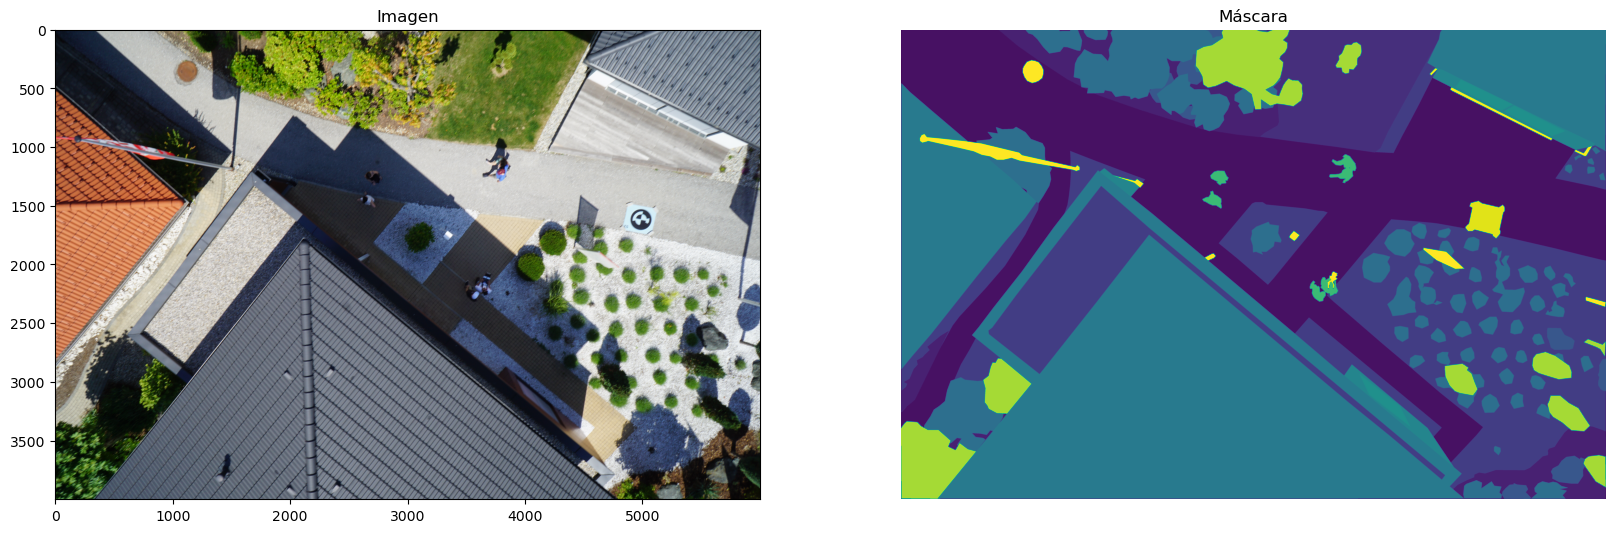

In [19]:
img = Image.open(IMAGE_PATH + df['id'][5] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][5] + '.png')
print('Tamaño de imagen:', np.asarray(img).shape)
print('Tamaño de máscara', np.asarray(mask).shape)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Imagen')

ax2.imshow(mask)
ax2.set_title('Máscara')
ax2.set_axis_off()

In [20]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

transform_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

transform_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, transform_train)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, transform_val)

#dataloader
batch_size= 2

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

### Modelo:

In [21]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=n_classes, activation=None, 
    encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [22]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

### Entrenamiento:

In [23]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

Loss Decreasing.. inf >> 1.873 
Epoch:1/15.. Train Loss: 2.748.. Val Loss: 1.873.. Train mIoU:0.048.. Val mIoU: 0.126.. Train Acc:0.244.. Val Acc:0.606.. Time: 4.01m
Loss Decreasing.. 1.873 >> 1.392 
Epoch:2/15.. Train Loss: 1.920.. Val Loss: 1.392.. Train mIoU:0.105.. Val mIoU: 0.141.. Train Acc:0.518.. Val Acc:0.654.. Time: 3.90m
Loss Not Decrease for 1 time
Epoch:3/15.. Train Loss: 1.580.. Val Loss: 1.401.. Train mIoU:0.118.. Val mIoU: 0.141.. Train Acc:0.552.. Val Acc:0.612.. Time: 3.84m
Loss Decreasing.. 1.401 >> 1.191 
Epoch:4/15.. Train Loss: 1.499.. Val Loss: 1.191.. Train mIoU:0.123.. Val mIoU: 0.163.. Train Acc:0.559.. Val Acc:0.648.. Time: 5.03m
Loss Decreasing.. 1.191 >> 1.063 
saving model...
Epoch:5/15.. Train Loss: 1.360.. Val Loss: 1.063.. Train mIoU:0.141.. Val mIoU: 0.167.. Train Acc:0.600.. Val Acc:0.690.. Time: 7.36m
Loss Decreasing.. 1.063 >> 1.059 
Epoch:6/15.. Train Loss: 1.316.. Val Loss: 1.059.. Train mIoU:0.151.. Val mIoU: 0.188.. Train Acc:0.611.. Val Acc:0.6

In [24]:
torch.save(model, './models/segmentation-unet-1.pt')

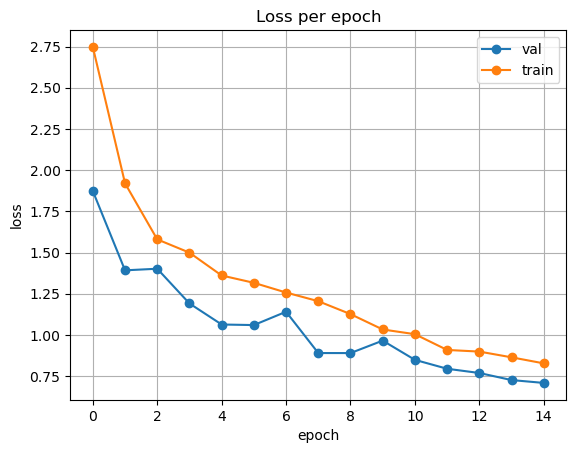

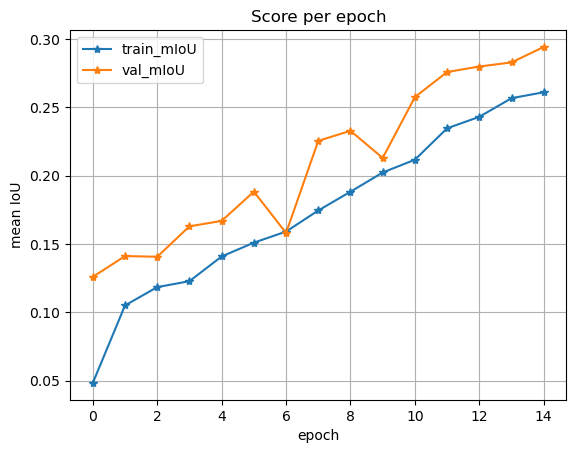

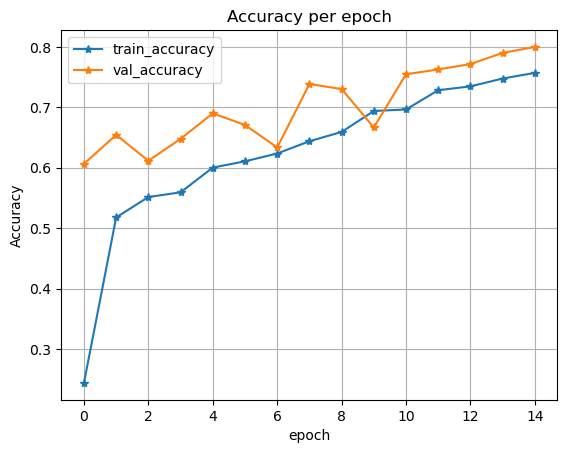

In [25]:
plt.plot(history['val_loss'], label='val', marker='o')
plt.plot( history['train_loss'], label='train', marker='o')
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()
    
plt.plot(history['train_miou'], label='train_mIoU', marker='*')
plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
plt.title('Score per epoch')
plt.ylabel('mean IoU')
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()

plt.plot(history['train_acc'], label='train_accuracy', marker='*')
plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
plt.title('Accuracy per epoch')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()

### Test:

Cargar el modelo:

In [26]:
model = torch.load('./models/segmentation-unet-1.pt')

In [27]:
transform_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_test, transform=transform_test)

In [28]:
image, mask = test_set[5]
pred_mask, score = predict_image_mask_miou(model, image, mask)

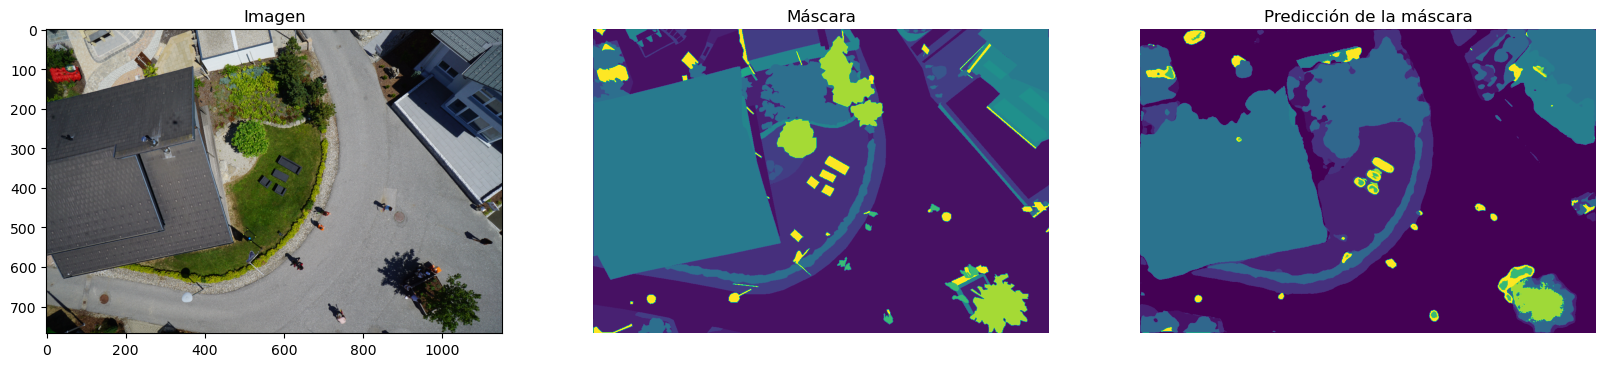

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Imagen')

ax2.imshow(mask)
ax2.set_title('Máscara')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('Predicción de la máscara'.format(score))
ax3.set_axis_off()

In [30]:
mob_miou = miou_score(model, test_set)
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.297423370528818


In [31]:
mob_acc = pixel_acc(model, test_set)
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.8129723537115403


### Cargar imágen del proyecto:

In [32]:
# Se lee la imagen según su indice
image = cv2.imread('./data/02/ORTO.tif')
# Convierte los colores de la imagen de BGR a RGB  
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)

aug = transform(image=image)
image = Image.fromarray(aug['image'])

In [33]:
pred_mask = predict_image_mask(model, image)

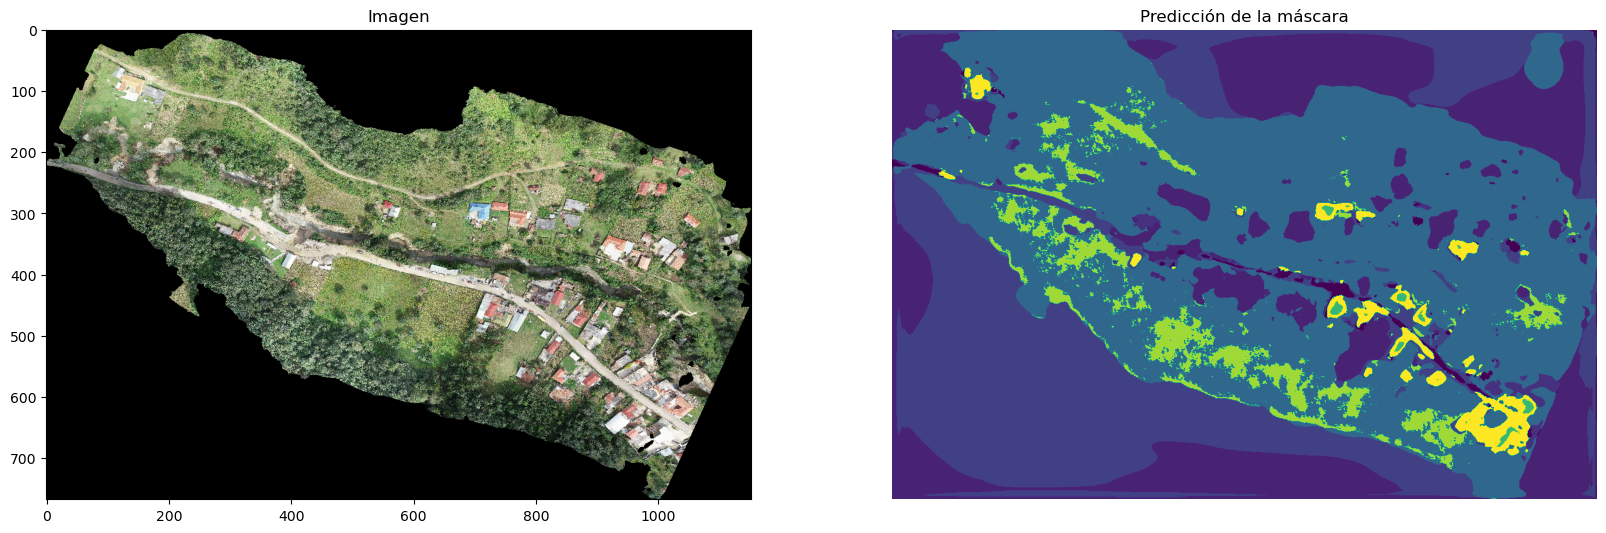

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Imagen')

ax2.imshow(pred_mask)
ax2.set_title('Predicción de la máscara'.format(score))
ax2.set_axis_off()

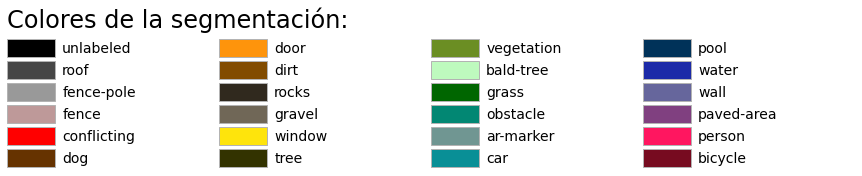

In [45]:
data = pd.read_csv("./segmentation/class_dict_seg.csv") 
data = data.set_index('name')
data = data.to_dict()
colors = dict()
for key in data[' r'].keys():
    colors[key] = (data[' r'][key]/255, data[' g'][key]/255, data[' b'][key]/255)
plot_colortable(colors, "Colores de la segmentación:")
plt.show()